# Initialise packages and load colours

In [1]:
using DifferentialEquations
using Plots; pyplot()
Plots.scalefontsizes(1.684)

# vibrant colour scheme - https://personal.sron.nl/~pault/
begin
    TolVibrantOrange = RGBA{Float64}(colorant"#EE7733")
    TolVibrantBlue = RGBA{Float64}(colorant"#0077BB")
    TolVibrantRed = RGBA{Float64}(colorant"#CC3311")
end;

# Define ODE models

In [2]:
# perfect adaptation model (equations (1) and (2))
function ffl_model(du,u,p,t)
    (S,k1,k2,k3,k4) = p
    du[1] = k1*(1/u[2])*(1/S[floor(Int,t)]) - k2*u[1] #h
    du[2] = k3*(1/S[floor(Int,t)]) - k4*u[2] #X
end

function repressive_hill_function(protein,hill_coefficient,repression_threshold)
    1.0/(1.0+(protein/repression_threshold)^hill_coefficient)
end

function activating_hill_function(protein,hill_coefficient,repression_threshold)
    1.0/(1.0+(protein/repression_threshold)^-hill_coefficient)
end

# extended model (equations (3), (4) and (5))
function extended_ffl_model(du,u,p,t)
    (S,k1,k2,k3,k4,k5,k6,k7,h1,p1,h2,p2,h3,p3) = p
    du[1] = k1*(1/u[2])*(1/S[floor(Int,t)])*repressive_hill_function(u[3],h1,p1) - k2*u[1] # Her6
    du[2] = k3*(1/S[floor(Int,t)]) - k4*u[2] # X
    du[3] = k5*repressive_hill_function(u[1],h2,p2) + k6*activating_hill_function(u[3],h3,p3) - k7*u[3] # Y
end;

# Solve and plot figures

In [3]:
# perfect adaptation model
total_time = 200
tspan = (1.,total_time);
min_S = 1.
max_S = 2.

# constant step mir-9 increase
const_step_S = vcat(fill(min_S,Int(total_time/4)),
              fill(min_S + (max_S-min_S)/3,Int(total_time/4)),
              fill(min_S + 2*(max_S-min_S)/3,Int(total_time/4)),
              fill(max_S,Int(total_time/4)));

# fold change step mir-9 increase
fc_step_S = vcat(fill(min_S,Int(total_time/4)),
            fill(min_S + 0.04*(max_S-min_S),Int(total_time/4)),
            fill(min_S + 0.4*(max_S-min_S),Int(total_time/4)),
            fill(max_S,Int(total_time/4)));

# linear mir-9 increase
linear_S = vcat(LinRange(min_S,max_S,Int(total_time)));

# define parameter values
h1,h2,h3 = 3.,3.,3.
p1,p2,p3 = 10.,1.,1.
k1,k2,k3,k4,k5,k6,k7 = 6.,2.,.1,.1,30.,100.,10.;

initial_state = [3.,1.];
initial_state_extended = [3.,min_S,0.];

#### Figure 6C

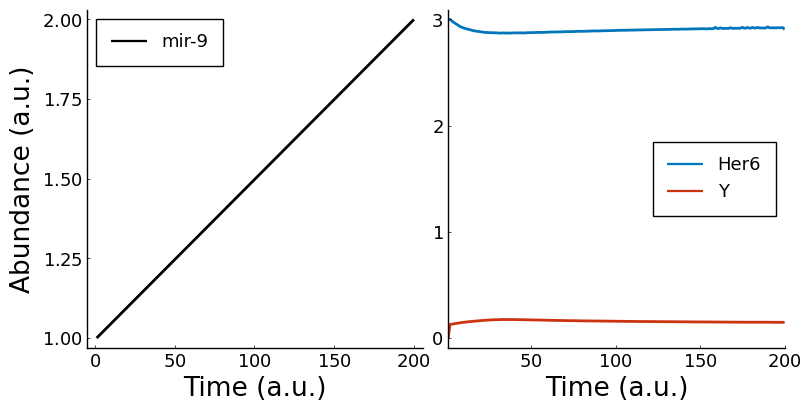

In [4]:
# extended model with linear increase in mir-9
linear_params = [linear_S,k1,k2,k3,k4,k5,k6,k7,h1,p1,h2,p2,h3,p3];
linear_prob = ODEProblem(extended_ffl_model, initial_state_extended, tspan, linear_params);
linear_sol = solve(linear_prob,dt=1,saveat=1.0)

plot1 = plot(
    LinRange(1,total_time,total_time),
    linear_S,
    label="mir-9",
    color=:black,
    xlabel="Time (a.u.)",
    ylabel="Abundance (a.u.)",
    linewidth=2,
    legend=:topleft
)

plot2 = plot(
    linear_sol,
    idxs=1,
    label="Her6",
    color=TolVibrantBlue,
    linewidth=2,
    legend=:right
)

plot!(
    linear_sol,
    idxs=3,
    label="Y",
    xlabel="Time (a.u.)",
    color=TolVibrantRed,
    linewidth=2
)

plot(plot1, plot2, layout=(1,2), grid=nothing, size=(800,400))
savefig("figures/figure_6c.eps")

#### Figure 6D

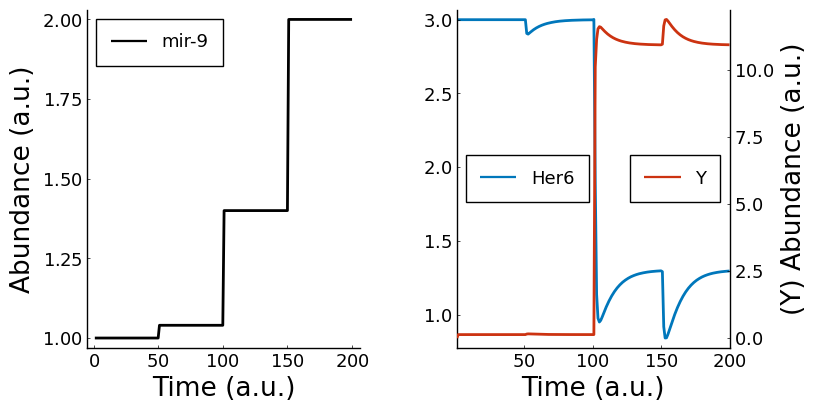

In [5]:
# extended model with fold change step wise increase in mir-9
fc_step_params = [fc_step_S,k1,k2,k3,k4,k5,k6,k7,h1,p1,h2,p2,h3,p3];
fc_step_prob = ODEProblem(extended_ffl_model, initial_state_extended, tspan, fc_step_params);
fc_step_sol = solve(fc_step_prob,dt=1,saveat=1.0);

plot1 = plot(
    LinRange(1,total_time,total_time),
    fc_step_S,
    label="mir-9",
    color=:black,
    xlabel="Time (a.u.)",
    ylabel="Abundance (a.u.)",
    linewidth=2,
    legend=:topleft
)

plot2 = plot(
    fc_step_sol,
    idxs=1,
    label="Her6",
    xlabel="Time (a.u.)",
    color=TolVibrantBlue,
    linewidth=2,
    # ylim = (-0.1,12.1),
    legend=:left
)

plot!(
    twinx(),
    fc_step_sol,
    idxs=3,
    label="Y",
    xlabel="",
    ylabel="(Y) Abundance (a.u.)",
    color=TolVibrantRed,
    linewidth=2,
    legend=:right
)

plot(plot1, plot2, layout=(1,2), grid=nothing, right_margin=15Plots.mm, size=(800,400))
savefig("figures/figure_6d.eps")

#### Figure S5B

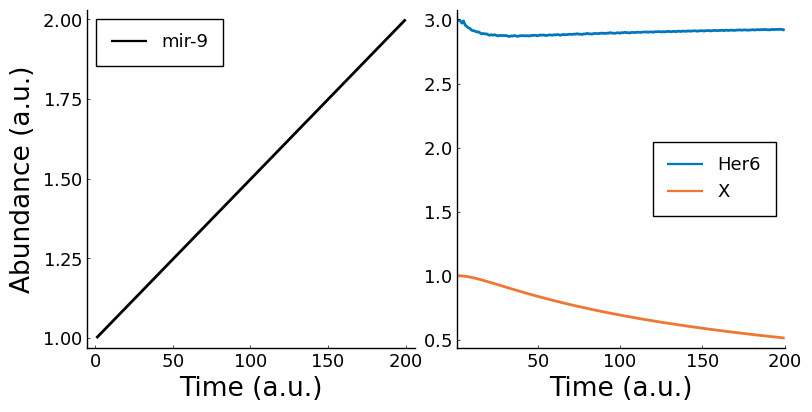

In [7]:
# perfect adaptation model with linear increase in mir-9
linear_params = [linear_S,k1,k2,k3,k4];
linear_prob = ODEProblem(ffl_model, initial_state, tspan, linear_params);
linear_sol = solve(linear_prob,dt=1,saveat=1.0)

plot1 = plot(
    LinRange(1,total_time,total_time),
    linear_S,
    label="mir-9",
    color=:black,
    xlabel="Time (a.u.)",
    ylabel="Abundance (a.u.)",
    linewidth=2,
    legend=:topleft
)

plot2 = plot(
    linear_sol,
    idxs=1,
    label="Her6",
    color=TolVibrantBlue,
    linewidth=2,
    legend=:right
)

plot!(
    linear_sol,
    idxs=2,
    label="X",
    color=TolVibrantOrange,
    linewidth=2,
    xlabel="Time (a.u.)"
)

plot(plot1, plot2, layout=(1,2), grid=nothing, size=(800,400))
savefig("figures/figure_s5b.eps")

#### Figure S5C

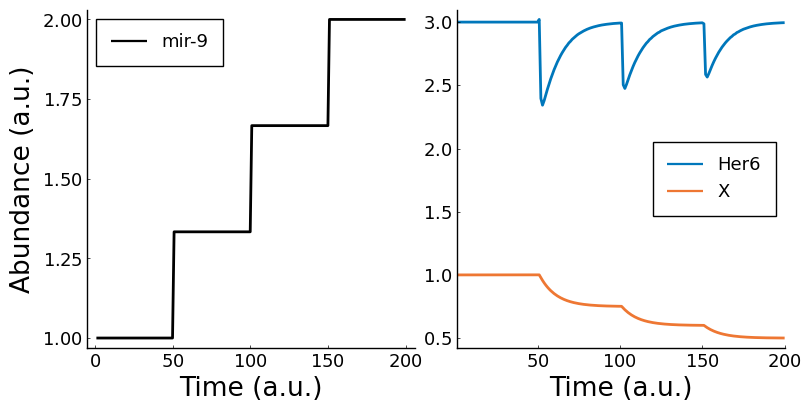

In [9]:
# perfect adaptation model with constant stepwise increase in mir-9
const_step_params = [const_step_S,k1,k2,k3,k4];
const_step_prob = ODEProblem(ffl_model, initial_state, tspan, const_step_params);
const_step_sol = solve(const_step_prob, dt=1, saveat=1.0);

plot1 = plot(
    LinRange(1,total_time,total_time),
    const_step_S,
    label="mir-9",
    color=:black,
    xlabel="Time (a.u.)",
    ylabel="Abundance (a.u.)",
    linewidth=2,
    legend=:topleft
)

plot2 = plot(
    const_step_sol,
    idxs=1,
    label="Her6",
    color=TolVibrantBlue,
    linewidth=2,
    legend=:right
)

plot!(
    const_step_sol,
    idxs=2,
    label="X",
    color=TolVibrantOrange,
    linewidth=2,
    xlabel="Time (a.u.)"
)

plot(plot1, plot2, layout=(1,2), grid=nothing, size=(800,400))
savefig("figures/figure_s5c.eps")

#### Figure S6A

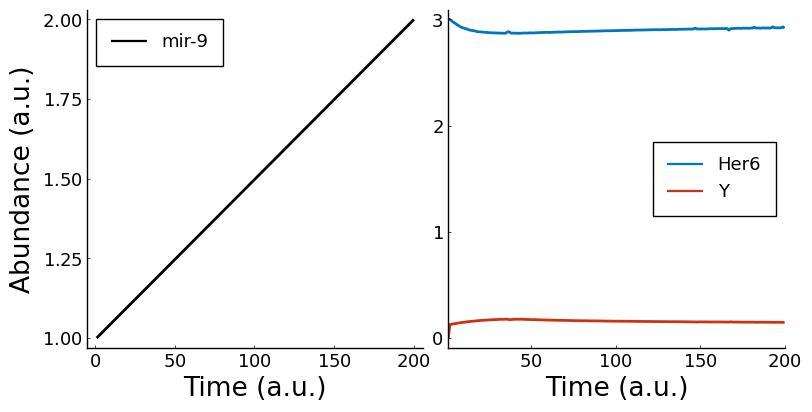

In [10]:
# extended model with linear increase in mir-9 and strong repression from Y
p1 = 2.0
linear_params = [linear_S,k1,k2,k3,k4,k5,k6,k7,h1,p1,h2,p2,h3,p3];
linear_prob = ODEProblem(extended_ffl_model, initial_state_extended, tspan, linear_params);
linear_sol = solve(linear_prob,dt=1,saveat=1.0)

plot1 = plot(
    LinRange(1,total_time,total_time),
    linear_S,
    label="mir-9",
    color=:black,
    xlabel="Time (a.u.)",
    ylabel="Abundance (a.u.)",
    linewidth=2,
    legend=:topleft
)

plot2 = plot(
    linear_sol,
    idxs=1,
    label="Her6",
    color=TolVibrantBlue,
    linewidth=2,
    legend=:right
)

plot!(
    linear_sol,
    idxs=3,
    label="Y",
    xlabel="Time (a.u.)",
    color=TolVibrantRed,
    linewidth=2
)

plot(plot1, plot2, layout=(1,2), grid=nothing, size=(800,400))
savefig("figures/figure_s6a.eps")

#### Figure S6B

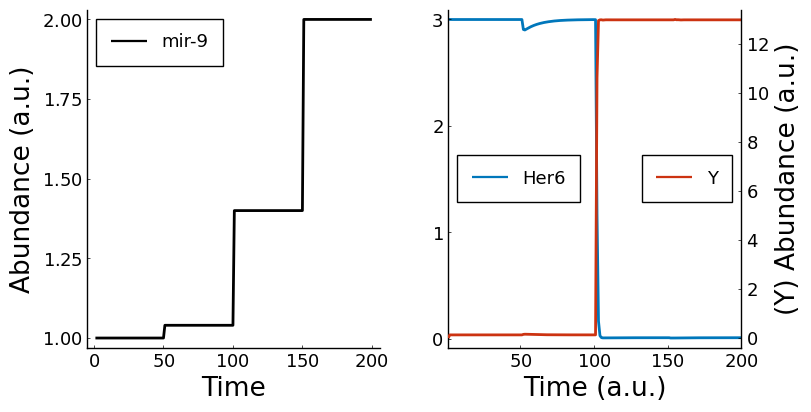

In [11]:
# extended model with fold change stepwise increase in mir-9 and strong repression from Y
p1 = 2.0
fc_step_params = [fc_step_S,k1,k2,k3,k4,k5,k6,k7,h1,p1,h2,p2,h3,p3];
fc_step_prob = ODEProblem(extended_ffl_model, initial_state_extended, tspan, fc_step_params);
fc_step_sol = solve(fc_step_prob,dt=1,saveat=1.0);

plot1 = plot(
    LinRange(1,total_time,total_time),
    fc_step_S,
    label="mir-9",
    color=:black,
    xlabel="Time",
    ylabel="Abundance (a.u.)",
    linewidth=2,
    legend=:topleft
)

plot2 = plot(
    fc_step_sol,
    idxs=1,
    label="Her6",
    xlabel="Time (a.u.)",
    color=TolVibrantBlue,
    linewidth=2,
    # ylim = (-0.1,13.2),
    legend=:left
)

plot!(
    twinx(),
    fc_step_sol,
    idxs=3,
    label="Y",
    xlabel="",
    ylabel="(Y) Abundance (a.u.)",
    legend=:right,
    color=TolVibrantRed,
    linewidth=2,
    margin=1000Plots.mm
)

plot(plot1, plot2, layout=(1,2), grid=nothing, right_margin=12Plots.mm, size=(800,400))
savefig("figures/figure_s6b.eps")